In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

### Clean and combine all NIST data files into one csv file

In [2]:
nb_path = pathlib.Path().resolve()
data_path = nb_path.parent / 'data' / 'processed' / 'NIST'

In [37]:
nist_files = [pd.read_csv(i, header=1, usecols=[0,8,10]) for i in glob.glob(os.path.join(data_path,'2*.csv'))]

In [38]:
def format_csv(df):
    #df = pd.read_csv(os.path.join(data_path,file), header=1, usecols=[0,8,10])
    
    df.drop(index=df.index[0], axis=0, inplace=True)

    df.columns=['Date', 'Collar', 'Flux']

    df['Flux'] = df['Flux'].astype(float)                            # convert datatypes
    df['Date'] = pd.to_datetime(df['Date'])
    
    all_dfs.append(df)

In [39]:
all_dfs = []

for file in nist_files:
    format_csv(file)

In [41]:
combined_csv = pd.concat(all_dfs)

In [42]:
combined_csv.to_csv(os.path.join(data_path,'all_nist.csv'), index=False, encoding='utf-8-sig')

#### Plot CO2 v. Temp

In [3]:
df = pd.read_csv(os.path.join(data_path, 'all_nist.csv'), parse_dates= ['Date']) # read in csv and parse date column

In [4]:
df['Collar'] = df['Collar'].apply(lambda x: x[5:] if 'NIST' in x else x)    # delete 'NIST' from some collar values

resp = df[df['Collar'].str.contains('R')]   # select only respiration

resp['Label'] = resp['Collar'].str[:3]   # add column for collar labels
resp['Type'] = resp['Collar'].str[0]     # add column for collar type

C:\Users\roseh\AppData\Local\Temp\ipykernel_9160\882991075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resp['Label'] = resp['Collar'].str[:3]   # add column for collar labels
C:\Users\roseh\AppData\Local\Temp\ipykernel_9160\882991075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resp['Type'] = resp['Collar'].str[0]     # add column for collar type


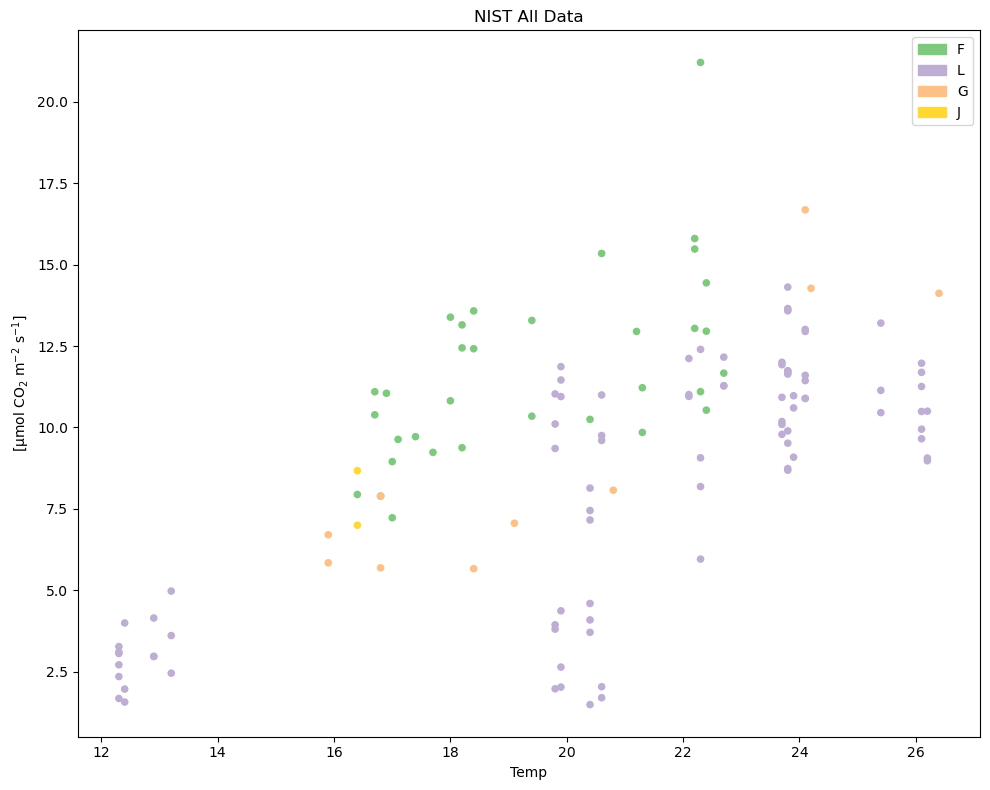

In [6]:
# plot all color-coded data

colors = ['#7fc97f','#beaed4','#fdc086','#ffd92f']
types = ['F', 'L', 'G', 'J']
color_dict = dict(zip(types,colors))

fig, ax = plt.subplots(figsize=(10,8))

resp.plot('Temp', 'Flux', kind='scatter', ax=ax, color=resp['Type'].replace(color_dict) )

# get legend info
patch_list = []
i = 0
for t in types:
    patch_list.append(mpatches.Patch(label=t, color=colors[i]))
    i += 1

plt.ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
plt.legend(handles=patch_list)
plt.title('NIST All Data')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_path, 'nist_all_data_plot.png'))
plt.close()

In [7]:
grouped_type = resp.groupby('Type')

In [8]:
def linear_fit(x,y):
    """Get slope, intercept and r2 for given x, y variables"""
    
    boo_x = ~np.isnan(x)
    boo_y = ~np.isnan(y)
    boo=np.logical_and(boo_x,boo_y)
    slope, intercept, r, p, std_err = stats.linregress(x[boo],y[boo])
    return slope,intercept, r

def myfunc(x, slope, intercept):
    """Equation of the regression line based on linear_fit"""
    
    return slope * x + intercept

In [9]:
def make_scatter_plots(grouped):
    """Plot respiration vs. temperature for each collar type"""
    
    colors = ['#7fc97f','#beaed4','#fdc086','#ffd92f']
    types = ['F', 'L', 'G', 'J']
    color_dict = dict(zip(types,colors))
    
    for name, group in grouped:
        if len(group) > 2:
            fig, ax = plt.subplots()
            group.plot('Temp', 'Flux', kind='scatter', color=color_dict[name], ax=ax)
        
            slope, intercept, r = linear_fit(group['Temp'], group['Flux'])
            x_range = np.arange(group['Temp'].min(), group['Temp'].max())
            model = myfunc(x_range,slope,intercept)
            ax.plot(x_range,model)
            ax.set_title(f'{name}: {np.around(r,3)}')
            ax.set_ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
            ax.set_ylim(0,25)
            plt.tight_layout()
            plt.show()
            fig.savefig(os.path.join(data_path,f'nist_plot_{name}.png'))
            plt.close()

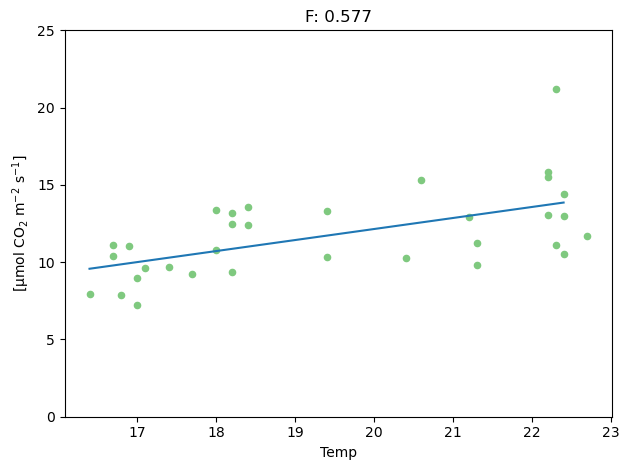

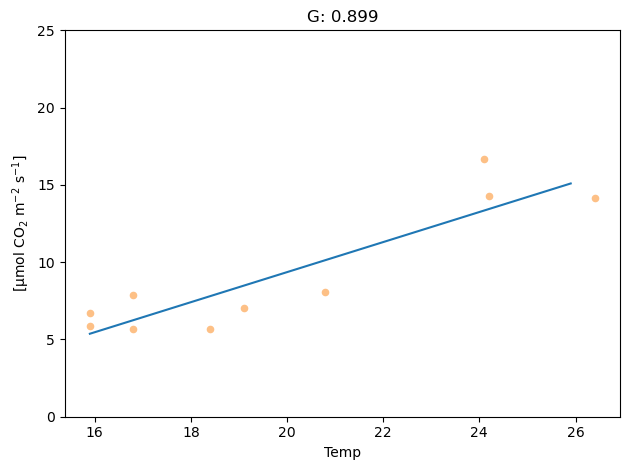

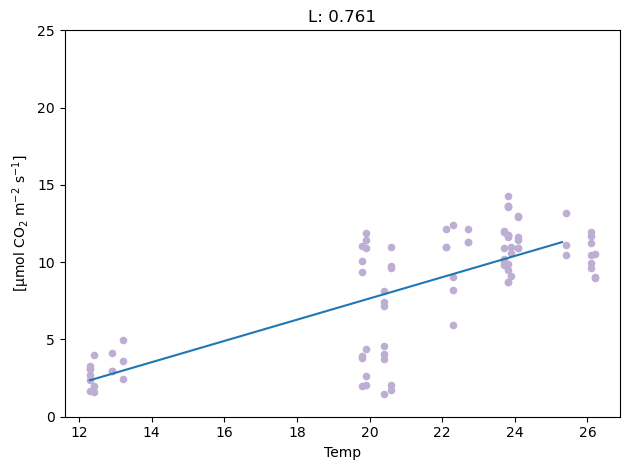

In [10]:
make_scatter_plots(grouped_type)